In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from LTH_helper import LTH
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import initializers
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow_model_optimization.sparsity.keras import strip_pruning

In [3]:
my_dataset = mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = my_dataset.load_data()
# X1 = train_images.reshape(-1, 784)/255 + np.random.normal(0.5, 0.1, (len(train_images), 784))
# X2 = train_images.reshape(-1, 784)/255 + np.random.normal(0.5, 0.1, (len(train_images), 784))
# X = np.vstack([X1, X2])
X = train_images.reshape(-1, 784)/255 
# y1 = train_labels.reshape(-1, 1)
# y = np.vstack([y1, y1])
y = train_labels.reshape(-1, 1)
X_test = test_images.reshape(-1, 784)/255
y_test = test_labels.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    

In [62]:
def get_model(compile_model_flag=True, lr=0.001):
    reduce = 1
    input_dim=784
    output_size = 10
    # Creo el modelo
    model = Sequential()
    model.add(Dense(784*2//reduce, name='hidden_1', kernel_initializer=initializers.glorot_uniform(), activation='relu',
                    input_dim=input_dim))
    model.add(Dense(784//reduce, name='hidden_2', kernel_initializer=initializers.glorot_uniform(), activation='relu'))
    model.add(Dense(output_size, name='Salida', kernel_initializer=initializers.glorot_uniform(), activation='softmax'))
    if compile_model_flag:
        compile_model(model, lr=lr)
    return model
model = get_model()

In [79]:
best_file = 'mlp.mnist.infer.hdf5'
initial_file = 'mlp.mnist.initial_weights.infer.hdf5'

In [83]:
def get_callbacks(filename):
    return [
        #ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=np.sqrt(0.1), patience=10, verbose=1, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
    ]


model = get_model(lr=0.001)
epochs = 10
batch_size = 256
# Save initial weights
model.save_weights(initial_file)
history = model.fit(X_train, 
           y_train,
           epochs=epochs, batch_size=batch_size, 
           validation_data = (X_val, y_val),
           verbose=2, 
           callbacks=get_callbacks(best_file)
          )

Epoch 1/10

Epoch 00001: val_accuracy improved from -inf to 0.96922, saving model to mlp.mnist.infer.hdf5
200/200 - 1s - loss: 0.2296 - accuracy: 0.9319 - val_loss: 0.0998 - val_accuracy: 0.9692
Epoch 2/10

Epoch 00002: val_accuracy improved from 0.96922 to 0.97533, saving model to mlp.mnist.infer.hdf5
200/200 - 1s - loss: 0.0775 - accuracy: 0.9759 - val_loss: 0.0777 - val_accuracy: 0.9753
Epoch 3/10

Epoch 00003: val_accuracy improved from 0.97533 to 0.97900, saving model to mlp.mnist.infer.hdf5
200/200 - 1s - loss: 0.0477 - accuracy: 0.9840 - val_loss: 0.0706 - val_accuracy: 0.9790
Epoch 4/10

Epoch 00004: val_accuracy improved from 0.97900 to 0.98000, saving model to mlp.mnist.infer.hdf5
200/200 - 1s - loss: 0.0314 - accuracy: 0.9898 - val_loss: 0.0709 - val_accuracy: 0.9800
Epoch 5/10

Epoch 00005: val_accuracy did not improve from 0.98000
200/200 - 0s - loss: 0.0246 - accuracy: 0.9918 - val_loss: 0.0726 - val_accuracy: 0.9792
Epoch 6/10

Epoch 00006: val_accuracy did not improve f

In [84]:
model.load_weights(best_file)

In [85]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 782us/step - loss: 0.0780 - accuracy: 0.9822


[0.07795220613479614, 0.982200026512146]

In [86]:
# if my_dataset == mnist:
#     model.load_weights('MNIST-LR-best_untrained_acc_36.3_46.6.hdf5')
# else:
#     model.load_weights('F-MNIST-LR-best_untrained_acc_10.3_50.9.hdf5')

In [87]:
for i, layer in enumerate(model.layers):
    sparcity = (layer.get_weights()[0]==0).sum()/np.product((layer.get_weights()[0]==0).shape)    
    print(f'{layer.name}: {sparcity}')

hidden_1: 0.0
hidden_2: 0.0
Salida: 0.0


In [88]:
X_test.shape

(10000, 784)

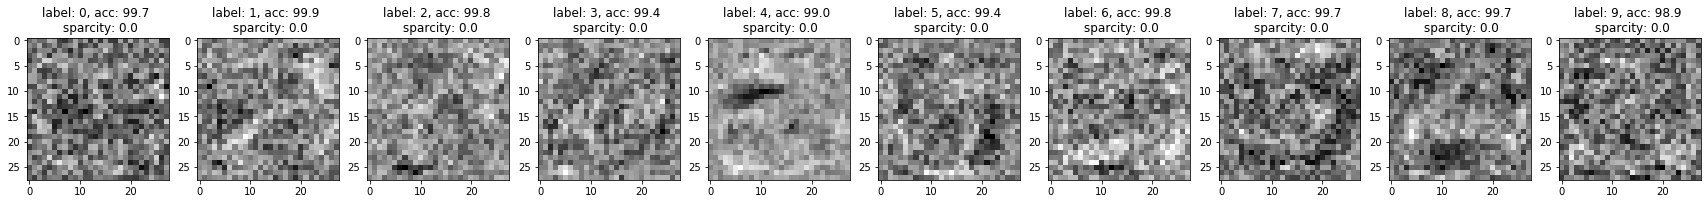

In [89]:
def plot_weights(model):
    f, axs = plt.subplots(1, 10, figsize=(30, 10))
    for number in range(10):
        w = model.get_weights()[0][:, number].reshape(28, 28)
        indexes = (y==number).reshape(-1)
        _, acc = model.evaluate(X[indexes], y[indexes], verbose=0)
        axs[number].imshow(w, cmap='gray')
        axs[number].set_title(f'label: {number}, acc: {int(acc*1000+0.5)/10} \n sparcity: {int((w==0).sum()/np.product(w.shape)*1000)/10}')
plot_weights(model)

In [90]:
from tensorflow.keras import backend as K

In [91]:
import numpy as np

In [92]:
model.evaluate(X, y)

1875/1875 [==============================] - 1s 761us/step - loss: 0.0189 - accuracy: 0.9954


[0.018927330151200294, 0.9953500032424927]

In [93]:
np.ones((28,28)).shape

(28, 28)

In [94]:
def get_input(out_index, std=0.01):
    img_width=28
    img_height=28
    new_image = X_test[(y_test==out_index).reshape(-1)][0].reshape(1, 28, 28) + np.random.normal(0, std, (1, img_width, img_height))
    return (new_image-new_image.min())/(new_image.max() - new_image.min())
    
def estimated_best_input(model, out_index = 1, lr = 1, steps=500, valid_image=0, std=0.25):
    img_width = 28
    img_height = 28
    if valid_image==1:
        input_img_data = get_input(out_index, std=std)
    elif valid_image==0:
        input_img_data = np.random.normal(0.5, std, (1, img_width, img_height))
    else: 
        input_img_data = 0.5*np.ones((1, 28,28))
    
    input_img = input_img_data.reshape(1, -1)
    tf_input = tf.Variable((input_img))
    acc_loss = []
    for i in range(500):
        with tf.GradientTape() as tape:
            loss = K.square(1-model(tf_input)[:, out_index])
#             loss = K.categorical_crossentropy(model(tf_input), tf.one_hot([out_index], 10))
        acc_loss.append(loss.numpy()[0])
        # print(loss.numpy(), end=', ')
        grads = tape.gradient(loss, tf_input)
        # print(grads.numpy().mean(), grads.numpy().std())
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-27)
        # print(grads.numpy().mean(), grads.numpy().std())
        tf_input = tf.Variable(tf_input - grads * lr)
    return tf_input.numpy().reshape(28, 28), acc_loss, input_img_data[0]
# estimated_input = estimated_best_input(model_pruned_layers_not_trained_best, 1, lr=1)
# 1, 8 , 9

In [95]:
from matplotlib.colors import Normalize

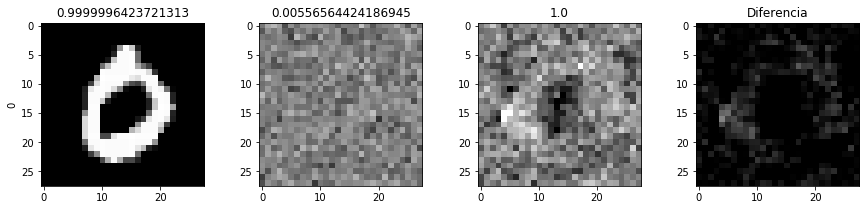

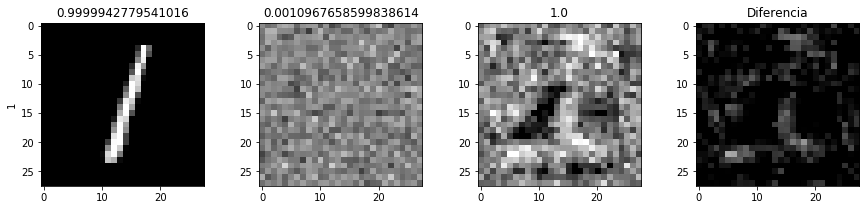

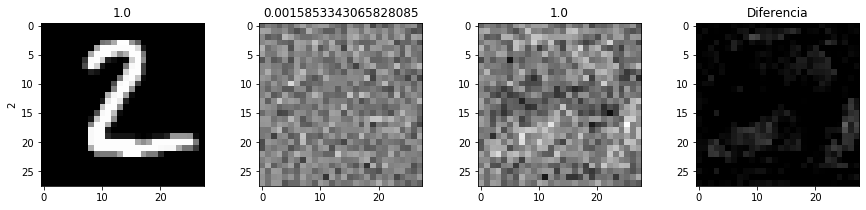

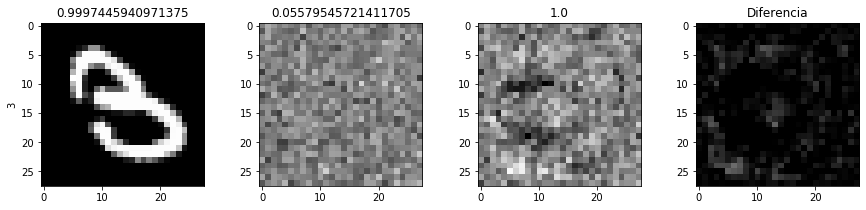

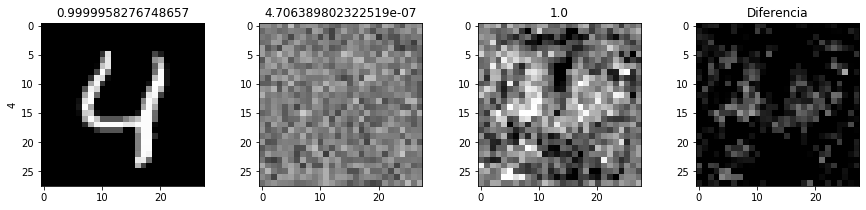

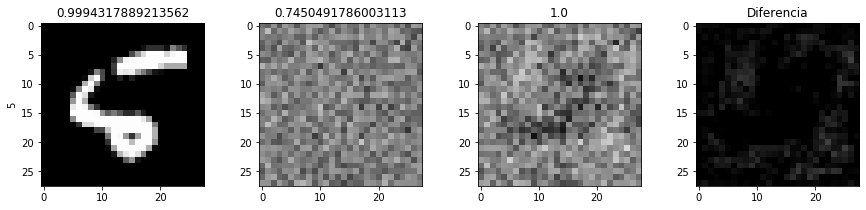

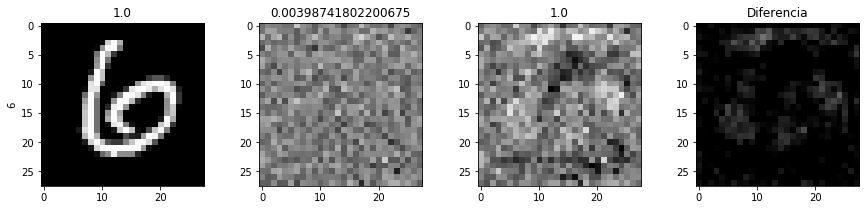

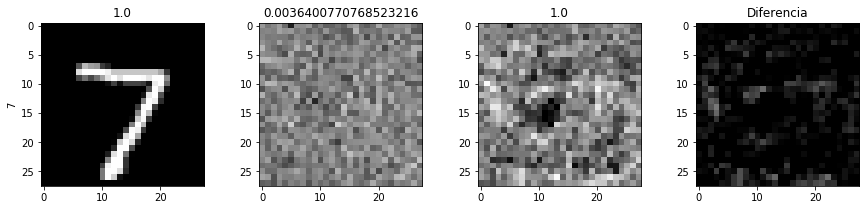

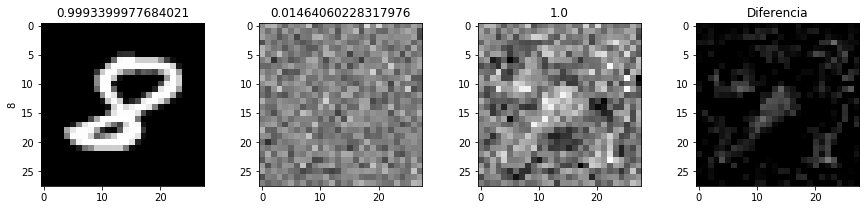

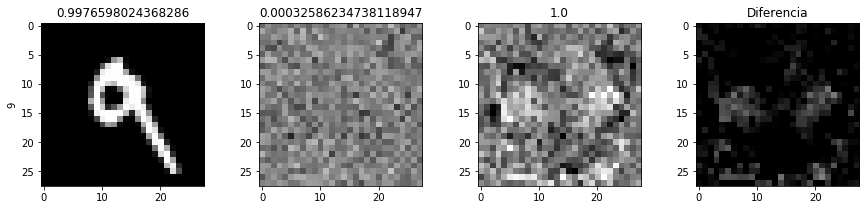

In [96]:
for out_index in range(10):
    estimated_input, acc_loss, input_img_data = estimated_best_input(model, out_index, lr=0.01, valid_image=0, std=0.1)
    clean_input = get_input(out_index, std=0.)[0]
    acc_clean = model.predict(clean_input.reshape(1,-1), verbose=0)[0][out_index]
    acc_est = model.predict(estimated_input.reshape(1,-1), verbose=0)[0][out_index]
    acc_orig = model.predict(input_img_data.reshape(1,-1), verbose=0)[0][out_index]
    f, ax = plt.subplots(1, 4, figsize=(15, 3))
    ax[0].imshow(clean_input, cmap='gray', norm=Normalize(0, 1))
    ax[0].set_title(f'{acc_clean}')
    ax[0].set_ylabel(out_index)
    ax[1].imshow(input_img_data, cmap='gray', norm=Normalize(0, 1))#, vmin=0., vmax=1.)
    ax[1].set_title(f'{acc_orig}')
    ax[2].imshow(estimated_input, cmap='gray', norm=Normalize(0, 1))
    ax[2].set_title(f'{acc_est}')
    ax[3].imshow(estimated_input-input_img_data, cmap='gray', norm=Normalize(0, 1))
    ax[3].set_title(f'Diferencia')
    plt.show()

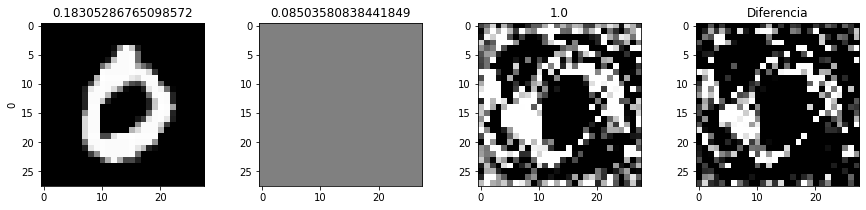

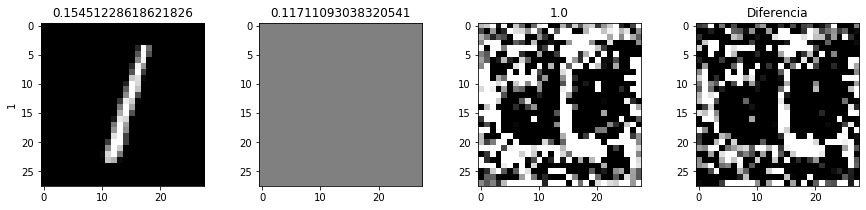

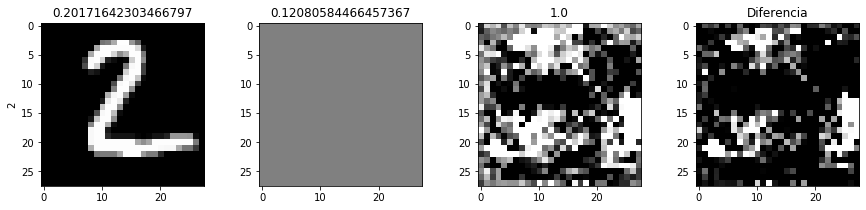

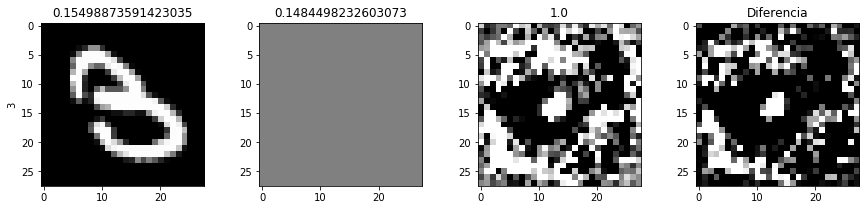

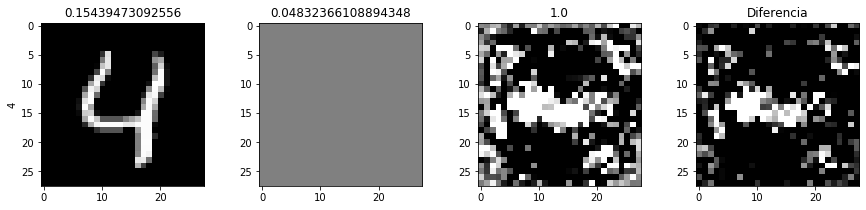

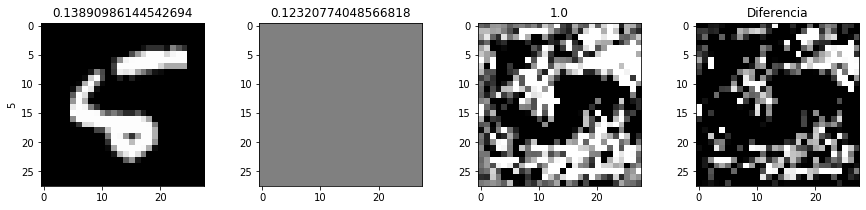

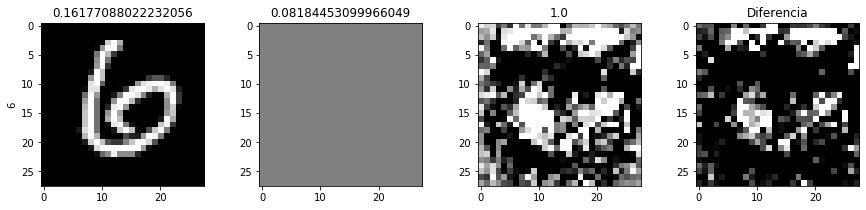

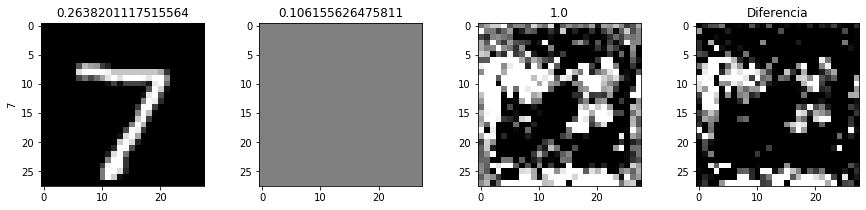

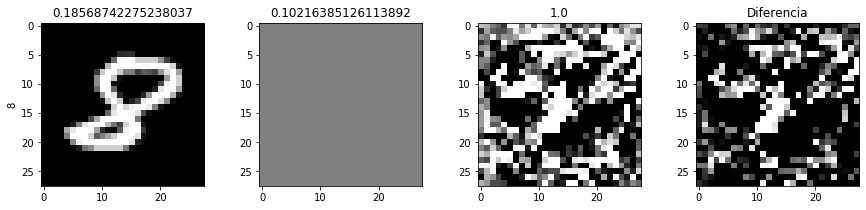

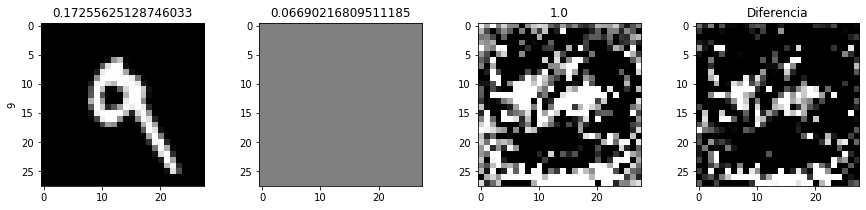

In [110]:
for out_index in range(10):
    estimated_input, acc_loss, input_img_data = estimated_best_input(model_pruned_layers_not_trained_best, out_index, lr=0.01, valid_image=2, std=0.1)
    clean_input = get_input(out_index, std=0.)[0]
    acc_clean = model_pruned_layers_not_trained_best.predict(clean_input.reshape(1,-1), verbose=0)[0][out_index]
    acc_est = model_pruned_layers_not_trained_best.predict(estimated_input.reshape(1,-1), verbose=0)[0][out_index]
    acc_orig = model_pruned_layers_not_trained_best.predict(input_img_data.reshape(1,-1), verbose=0)[0][out_index]
    f, ax = plt.subplots(1, 4, figsize=(15, 3))
    ax[0].imshow(clean_input, cmap='gray', norm=Normalize(0, 1))
    ax[0].set_title(f'{acc_clean}')
    ax[0].set_ylabel(out_index)
    ax[1].imshow(input_img_data, cmap='gray', norm=Normalize(0, 1))#, vmin=0., vmax=1.)
    ax[1].set_title(f'{acc_orig}')
    ax[2].imshow(estimated_input, cmap='gray', norm=Normalize(0, 1))
    ax[2].set_title(f'{acc_est}')
    ax[3].imshow(estimated_input-input_img_data, cmap='gray', norm=Normalize(0, 1))
    ax[3].set_title(f'Diferencia')
    plt.show()

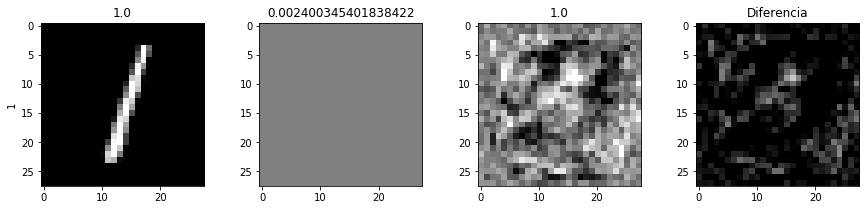

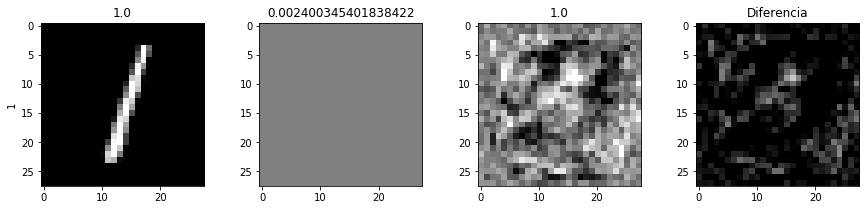

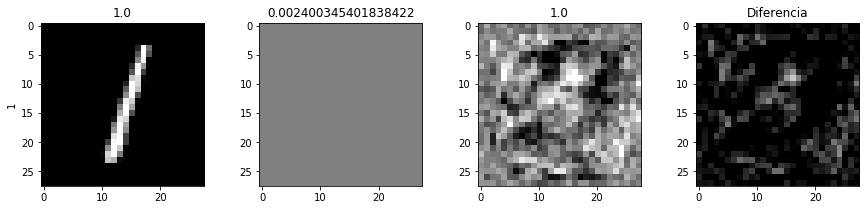

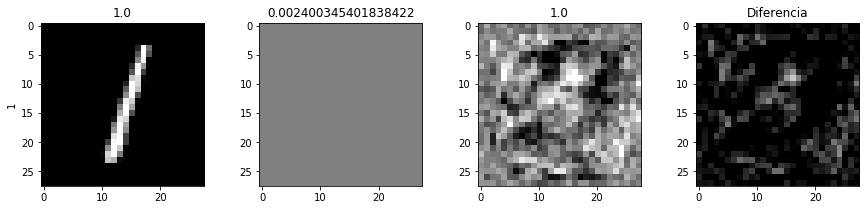

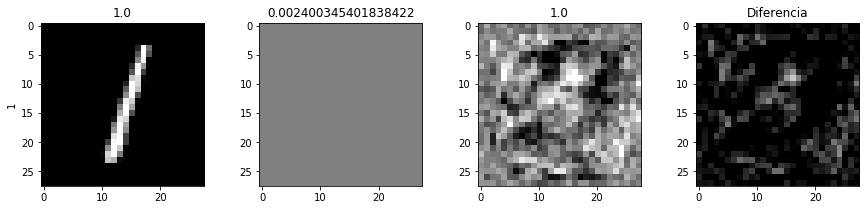

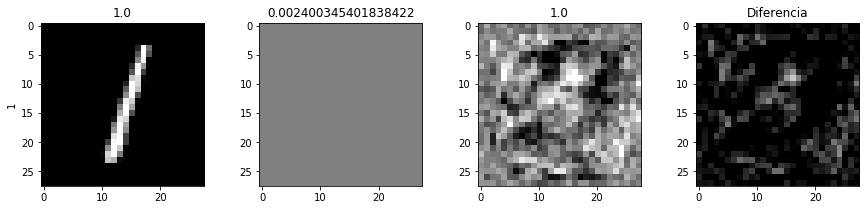

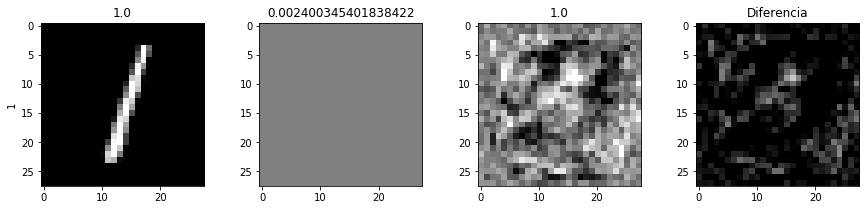

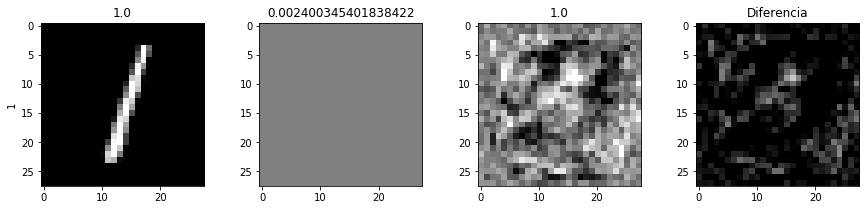

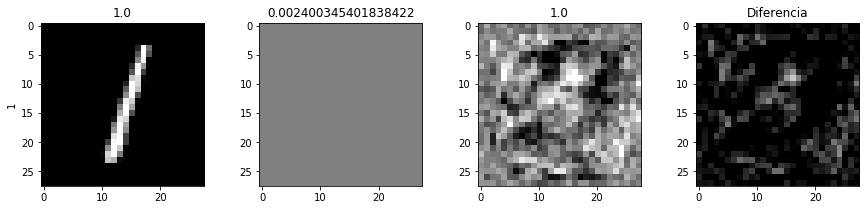

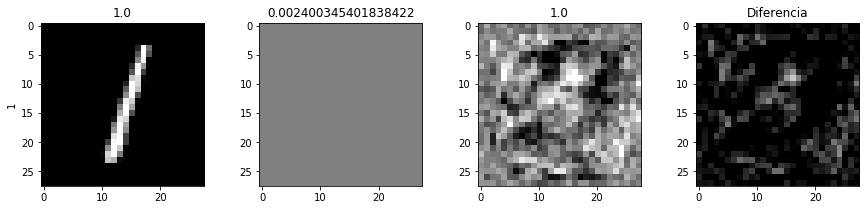

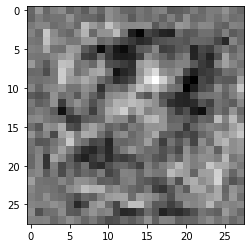

In [58]:
plt.imshow(estimated_input_sum/10, cmap='gray')

In [101]:
lth = LTH(get_model)
pms = np.linspace(0.001, 0.999, 50)
accs_nt = []
best_acc = 0

for pm in pms:
    # Devuelve el modelo pruneado en funcion del entrenamiento
    model_pruned_layers = lth.get_prunned_model(best_file, pm)
    # Coloca los pesos iniciales en los lugares sin prunear
    model_pruned_layers_not_trained = lth.initialize_sparse_model(initial_file, model_pruned_layers, pm)
    actual_acc = model_pruned_layers_not_trained.evaluate(X_test, y_test, verbose=0)[1]
    print(actual_acc, pm)
    if actual_acc>best_acc:
        best_acc = actual_acc
        best_pm = pm
        model_pruned_layers_not_trained_best = strip_pruning(model_pruned_layers_not_trained)
    accs_nt.append(actual_acc)

0.09799999743700027 0.001
0.2888999879360199 0.02136734693877551
0.5649999976158142 0.04173469387755102
0.7080000042915344 0.06210204081632653
0.8406999707221985 0.08246938775510204
0.866599977016449 0.10283673469387755
0.885699987411499 0.12320408163265306
0.8945000171661377 0.14357142857142857
0.8819000124931335 0.16393877551020408
0.8898000121116638 0.1843061224489796
0.8974999785423279 0.2046734693877551
0.9045000076293945 0.2250408163265306
0.9065999984741211 0.24540816326530612
0.8978000283241272 0.26577551020408163
0.9016000032424927 0.28614285714285714
0.9031999707221985 0.30651020408163265
0.8865000009536743 0.32687755102040816
0.901199996471405 0.3472448979591837
0.899399995803833 0.3676122448979592
0.8884999752044678 0.3879795918367347
0.9010999798774719 0.4083469387755102
0.899399995803833 0.4287142857142857
0.8901000022888184 0.4490816326530612
0.8988000154495239 0.46944897959183673
0.8934999704360962 0.48981632653061224
0.8884999752044678 0.5101836734693878
0.881399989128

In [102]:
for i, layer in enumerate(model_pruned_layers_not_trained_best.layers):
    sparcity = (layer.get_weights()[0]==0).sum()/np.product((layer.get_weights()[0]==0).shape)    
    print(f'{layer.name}: {sparcity}')

hidden_1: 0.7545919994273219
hidden_2: 0.7545919994273219
Salida: 0.7545918367346939


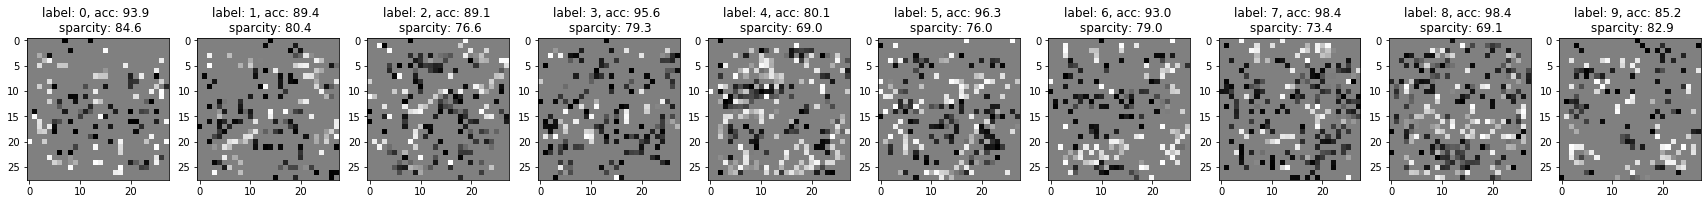

In [103]:
compile_model(model_pruned_layers_not_trained_best)
plot_weights(model_pruned_layers_not_trained_best)

In [105]:
model_pruned_layers_not_trained_best.evaluate(X_test, y_test)

313/313 [==============================] - 0s 783us/step - loss: 1.6546 - accuracy: 0.9066


[1.65462064743042, 0.9065999984741211]